In [1]:
import os
!pip install scikit-learn
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize

In [2]:

!pip install Pillow
# Define the paths to your dataset directories
clean_images_dir = 'data/train/clean/'
noisy_images_dir = 'data/train/noisy/'

# Define desired image size (adjust as needed)
image_size = (128, 128)


def load_images_from_folder(folder, size):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path is not None:
            img = load_img(img_path, target_size=size, color_mode='rgb')
            img = img_to_array(img)
            images.append(img)
    return np.array(images)

!pip install Pillow


# Load and preprocess the data
clean_images = load_images_from_folder(clean_images_dir, image_size)
noisy_images = load_images_from_folder(noisy_images_dir, image_size)


In [3]:
# Normalize the images to [0, 1]
clean_images_normalized = normalize(clean_images, axis=1)
noisy_images_normalized = normalize(noisy_images, axis=1)

In [4]:
# Split the dataset into training and testing sets (adjust split ratio as needed)
x_train_noisy, x_test_noisy, x_train_clean, x_test_clean = train_test_split(
    noisy_images_normalized, clean_images_normalized, test_size=0.2, random_state=42
)

In [8]:
print(f"Training data (noisy): {x_train_noisy.shape}")  # e.g., (num_samples, 128, 128, 3)
print(f"Training data (clean): {x_train_clean.shape}")  # e.g., (num_samples, 128, 128, 3)
print(f"Test data (noisy): {x_test_noisy.shape}")       # e.g., (num_samples, 128, 128, 3)
print(f"Test data (clean): {x_test_clean.shape}")       # e.g., (num_samples, 128, 128, 3)


Training data (noisy): (1599, 128, 128, 3)
Training data (clean): (1599, 128, 128, 3)
Test data (noisy): (400, 128, 128, 3)
Test data (clean): (400, 128, 128, 3)


In [9]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

# Assuming x_train_noisy and x_train_clean have the same shape
img_shape = x_train_noisy.shape[1:]  # This takes the shape of the data excluding the batch dimension
def build_autoencoder(img_shape):
    input_img = Input(shape=img_shape)
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    
    return autoencoder


In [10]:
autoencoder = build_autoencoder(img_shape)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248  

In [11]:
# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# Train the model
history = autoencoder.fit(
    x_train_noisy, x_train_clean,  # Using noisy images as input and clean images as target
    epochs=50,  # Number of epochs to train for
    batch_size=128,  # Batch size for training
    shuffle=True,  # Shuffle the training data
    validation_data=(x_test_noisy, x_test_clean),  # Validation data for monitoring
    verbose=1  # Show training log
)


Epoch 1/50
13/13 [==============================] - 13s 974ms/step - loss: 0.1411 - val_loss: 0.0253
Epoch 2/50
13/13 [==============================] - 13s 964ms/step - loss: 0.0097 - val_loss: 0.0077
Epoch 3/50
13/13 [==============================] - 13s 965ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 4/50
13/13 [==============================] - 13s 964ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 5/50
13/13 [==============================] - 13s 989ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 6/50
13/13 [==============================] - 13s 1s/step - loss: 0.0078 - val_loss: 0.0078
Epoch 7/50
13/13 [==============================] - 13s 1s/step - loss: 0.0078 - val_loss: 0.0078
Epoch 8/50
13/13 [==============================] - 13s 1s/step - loss: 0.0078 - val_loss: 0.0078
Epoch 9/50
13/13 [==============================] - 14s 1s/step - loss: 0.0078 - val_loss: 0.0078
Epoch 10/50
13/13 [==============================] - 14s 1s/step - loss: 0.0078 - val_loss: 0.0078
Epoc

In [14]:
# Optional: Save the trained model
autoencoder.save('autoencoder_model.h5')

  Using cached matplotlib-3.8.2-cp39-cp39-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached contourpy-1.2.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.48.1-cp39-cp39-macosx_10_9_universal2.whl.metadata (158 kB)
  Using cached kiwisolver-1.4.5-cp39-cp39-macosx_11_0_arm64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.1.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached importlib_resources-6.1.1-py3-none-any.whl.metadata (4.1 kB)
Using cached matplotlib-3.8.2-cp39-cp39-macosx_11_0_arm64.whl (7.5 MB)
Using cached contourpy-1.2.0-cp39-cp39-macosx_11_0_arm64.whl (242 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.48.1-cp39-cp39-macosx_10_9_universal2.whl (2.8 MB)
Using cached importlib_resources-6.1.1-py3-none-any.whl (33 kB)
Using cached kiwisolver-1.4.5-cp39-cp39-macosx_11_0_arm64.whl (66 kB)
Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)


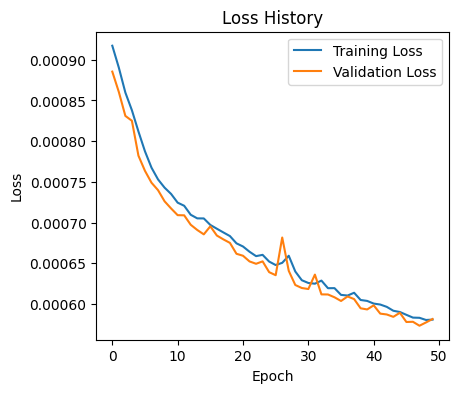

In [16]:
!pip install matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

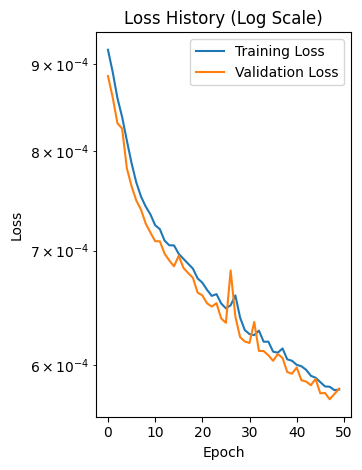

In [17]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss History (Log Scale)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
#Step 1: Load the Noisy Test Images
def load_images_from_folder(folder, size=(128, 128)):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path is not None:
            img = load_img(img_path, target_size=size, color_mode='rgb')
            img = img_to_array(img)
            images.append(img)
            filenames.append(filename)
    return np.array(images), filenames

In [20]:
# Adjust the path and size as necessary
test_noisy_images, filenames = load_images_from_folder('data/test/', size=(128, 128))
test_noisy_images = test_noisy_images.astype('float32') / 255.0


In [21]:
#Step 2: Use the Model to Denoise the Test Images
# Assuming your autoencoder model is loaded and named 'autoencoder'
denoised_images = autoencoder.predict(test_noisy_images)


12/12 [==============================] - 1s 48ms/step


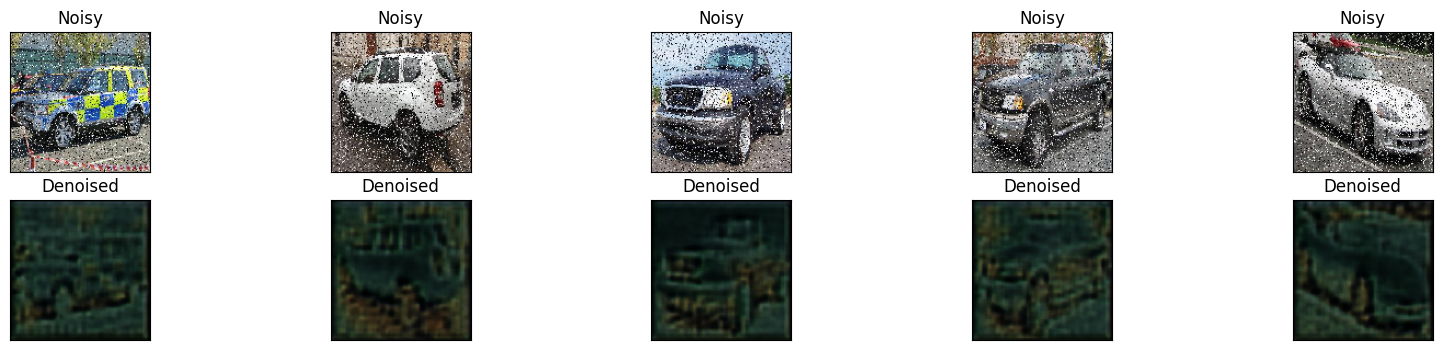

In [22]:
#3. Visualize or Save the Denoised Images
def display_images(noisy_images, denoised_images, n=5):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original noisy image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(noisy_images[i])
        plt.title("Noisy")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display denoised image
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(denoised_images[i])
        plt.title("Denoised")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Display the first 5 noisy and denoised images for comparison
display_images(test_noisy_images, denoised_images, n=5)


In [24]:
from PIL import Image
def save_images(images, filenames, save_dir='data/denoised/'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for img, filename in zip(images, filenames):
        img = Image.fromarray(np.uint8(img * 255))
        img.save(os.path.join(save_dir, filename))

# Save the denoised images
save_images(denoised_images, filenames)
